# ¿Qué juegos tienen éxito?

Trabajas para la tienda online Ice que vende videojuegos por todo el mundo. Las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos están disponibles en fuentes abiertas. Tienes que identificar patrones que determinen si un juego tiene éxito o no. Esto te permitirá detectar proyectos prometedores y planificar campañas publicitarias.

Delante de ti hay datos que se remontan a 2016. Imaginemos que es diciembre de 2016 y estás planeando una campaña para 2017.

Lo importante es adquirir experiencia de trabajo con datos. Realmente no importa si estás pronosticando las ventas de 2017 en función de los datos de 2016 o las ventas de 2027 en función de los datos de 2026.

El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

# 1. Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
from scipy import stats
from math import factorial
import seaborn as sns
from matplotlib import pyplot as plt

### 1.1 Cargar Datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_games = pd.read_csv('/datasets/games.csv')
df_games.info()
print()
print(df_games.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701


# 2. Preparar los Datos

### 2.1 Revision de Datos/columnas

In [3]:
# Revisar datos nulos por columna
print(df_games.isnull().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


In [4]:
# Revisar los datos contenidos por columna, para revisar si los tipos de datos son correctos
print(df_games.sample(5))
print()
print(df_games['Platform'].unique())

                                                    Name Platform  \
9299                    Fashion Studio: Paris Collection       DS   
3434                                      Romancing SaGa      PS2   
2614                                           Too Human     X360   
5620                                         Rally Cross       PS   
11915  Kidou Senshi Gundam: Giren no Yabou - Axis no ...      PSP   

       Year_of_Release         Genre  NA_sales  EU_sales  JP_sales  \
9299            2009.0          Misc      0.13      0.00      0.00   
3434            2005.0  Role-Playing      0.06      0.04      0.47   
2614            2008.0  Role-Playing      0.38      0.29      0.03   
5620            1997.0        Racing      0.18      0.12      0.00   
11915           2009.0      Strategy      0.00      0.00      0.07   

       Other_sales  Critic_Score User_Score Rating  
9299          0.01           NaN        tbd      E  
3434          0.01          58.0          8   E10+  
2614 

In [5]:
# Mostrar los datos estadisticos del dataframe
df_games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


### 2.2 Ajuste de nombres de columnas

In [6]:
# Reemplazar los nombres de columnas a minusculas
print(df_games.columns)
print()
new_col_names = []
for old_name in df_games.columns:
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_names.append(name_no_spaces)

df_games.columns = new_col_names
print(df_games.columns)

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### 2.3 Valores Ausentes

In [7]:
# Revision de los datos nuevamente
print(df_games.dtypes)

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object


In [8]:
# Para el caso de la columnas "name" and "genre", solo existen 2 valores nulos, por los que, considero no exista mayor problema si se procede a eliminar, 
# para no inflar o alterar los valores del resto de los datos
df_games.dropna(subset=['name','genre'], inplace=True)

# Revisar que si se hayan eliminado correctamente las columnas "name" y "genre"
df_games.isnull().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [9]:
print(df_games[df_games['year_of_release'].isna()])

                                    name platform  year_of_release  \
183                      Madden NFL 2004      PS2              NaN   
377                     FIFA Soccer 2004      PS2              NaN   
456           LEGO Batman: The Videogame      Wii              NaN   
475           wwe Smackdown vs. Raw 2006      PS2              NaN   
609                       Space Invaders     2600              NaN   
...                                  ...      ...              ...   
16373  PDC World Championship Darts 2008      PSP              NaN   
16405                      Freaky Flyers       GC              NaN   
16448                          Inversion       PC              NaN   
16458        Hakuouki: Shinsengumi Kitan      PS3              NaN   
16522                       Virtua Quest       GC              NaN   

              genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
183          Sports      4.26      0.26      0.01         0.71          94.0   

Mis comentarios: Aqui de entrada, puedo visualizar en ese muestreo que, las ventas para la mayoria de los valores NA de la columna "year_of_release" son relativamente bajos, a comparacion del resto de las columnas, cuyos años de lanzamiento si se encuentran. 

In [10]:
# De la columna "year_of_release", revisar si son datos relevantes "con ventas"
df_games_yor_na = df_games[df_games['year_of_release'].isna()]

In [11]:
#Eliminar valores nulos de "year_of_release"
df_games = df_games.dropna(subset=['year_of_release'])

### 2.4 Cambio tipo de Datos

In [12]:
# Cambio de tipo de valores a "int"
df_games["year_of_release"] = df_games["year_of_release"].astype(int)

In [13]:
print(df_games.isnull().sum())

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64


In [14]:
# Conversion de datos en columna "user_score", reemplazando tbd a NA
df_games["user_score"] = df_games["user_score"].replace("tbd", pd.NA)
df_games["user_score"] = pd.to_numeric(df_games["user_score"], errors="coerce")

In [15]:
# Revision de los datos nuevamente
print(df_games.dtypes)

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object


Mis comentarios: <br>
- Respecto a "name" y "genre", solo eran 2 filas nulas, por lo que procedi a borrarlas, ya que no afectarian en futuro analisis <br>
- Respecto a "year_of_release", se encontraban 269 datos nulos. Procedi a revisar los datos contenidos en las ventas (las cuales son importantes para futuro analisis), y se determino que las ventas no son significativas y no impactarian en futuros analisis, por lo que se eliminaron. El tipo de datos en esta columna se cambio a "int". <br>
- Respecto a "user_score", se cambiaron los valores "tbd" a NaN, para su posterior analisis <br>
- Respecto a "critic_score" y "rating", son tantos los valores nulos, que si seria significativo el eliminarlos o alterarlos, por lo que se procedio a dejarlos asi.


### 2.5 Valores Duplicados

In [16]:
# Conocer si existen filas duplicadas
df_games["nueva_columna"] = df_games["name"].astype(str) + "_" + df_games['platform'].astype(str) + "_" + df_games["genre"].astype(str) + "_" + df_games['year_of_release'].astype(str)
print(df_games['nueva_columna'].duplicated().sum())

1


In [17]:
# borrar la unica fila duplicada
df_games = df_games.drop_duplicates(subset=['nueva_columna']).reset_index(drop=True)
print(df_games['nueva_columna'].duplicated().sum())

0


### 2.6 Ventas Totales

In [18]:
# Calculo de Ventas totales
df_games["global_sales"] = df_games[["na_sales", "eu_sales", "jp_sales", "other_sales"]].sum(axis=1)

# 3. Analizar los Datos

### 3.1 Juegos por Año

In [19]:
games_per_year = df_games.groupby('year_of_release')['name'].count()
print(games_per_year)

year_of_release
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      60
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     652
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64


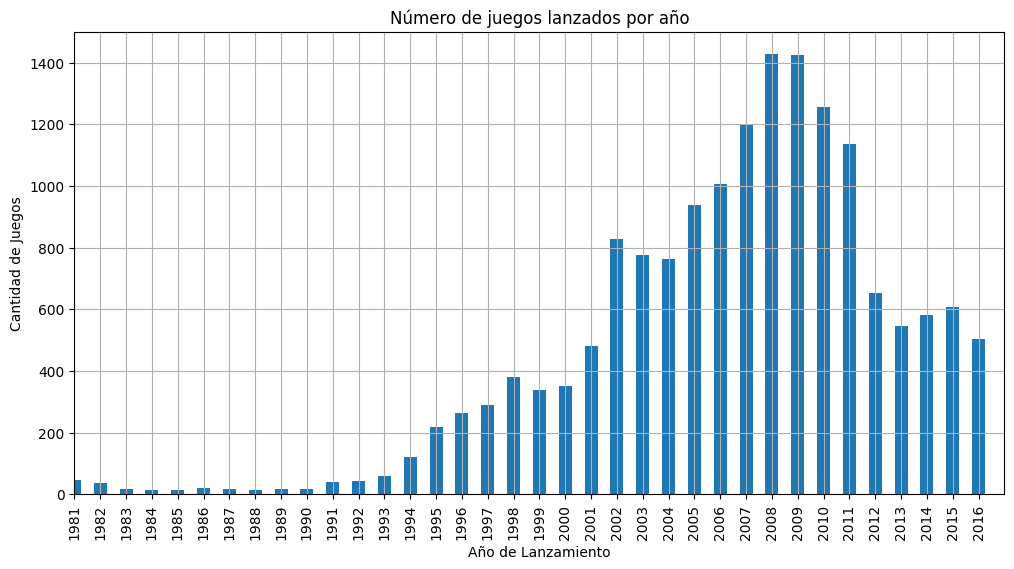

In [20]:
# Analizar los datos graficamente
games_per_year.plot(title="Número de juegos lanzados por año",
    xlabel= 'Año de Lanzamiento',
    ylabel= 'Cantidad de Juegos',
    grid=True,
    kind="bar",
    rot= 90,
    figsize=[12,6])
plt.xlim(1, len(games_per_year))
plt.show()

¿Son significativos los datos de cada período? <br>
Se puede observar que existe un sesgo hacia la izquierda, concentrandose la mayoria de los datos entre el 2002 - 2011. Encontrando el pico en 2008 y 2009. Esto demuestra que, partiendo de 1994 la cantidad de juegos producidos fue incrementando gradualmente. 

### 3.2 Ventas totales por Plataforma

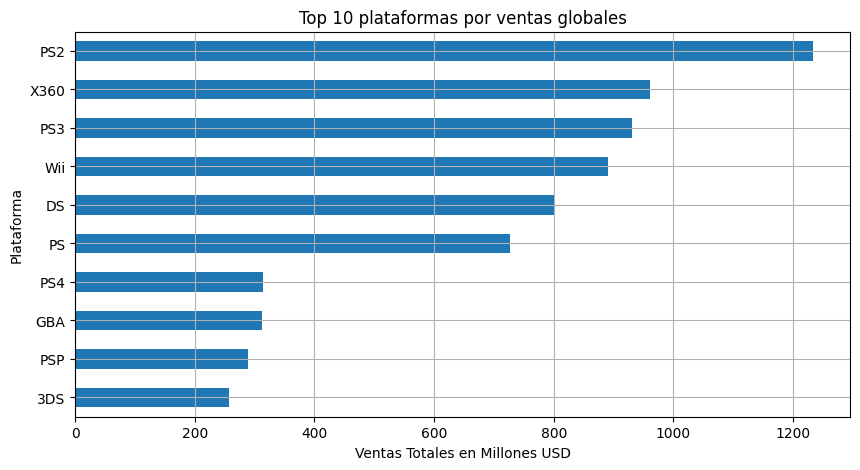

In [21]:
# Observa cómo varían las ventas de una plataforma a otra. 
sales_per_platform = df_games.groupby(by='platform')['global_sales'].sum()
sales_per_platform = sales_per_platform.sort_values(ascending=False)

# Graficar las observaciones
ax = sales_per_platform.head(10).plot(
    title= 'Top 10 plataformas por ventas globales',
    kind="barh",
    figsize=(10,5),
    grid=True,
    ylim=(15,30),
    xlabel="Plataforma",
    ylabel="Ventas Totales en Millones USD"
)
ax.set_xlabel("Ventas Totales en Millones USD")
ax.invert_yaxis()
plt.show()

Mis Comentarios: <br>
Historicamente las plataformas con mayores ventas totales son: PS2, X360, PS3, Nintendo Wii y Nintendo DS

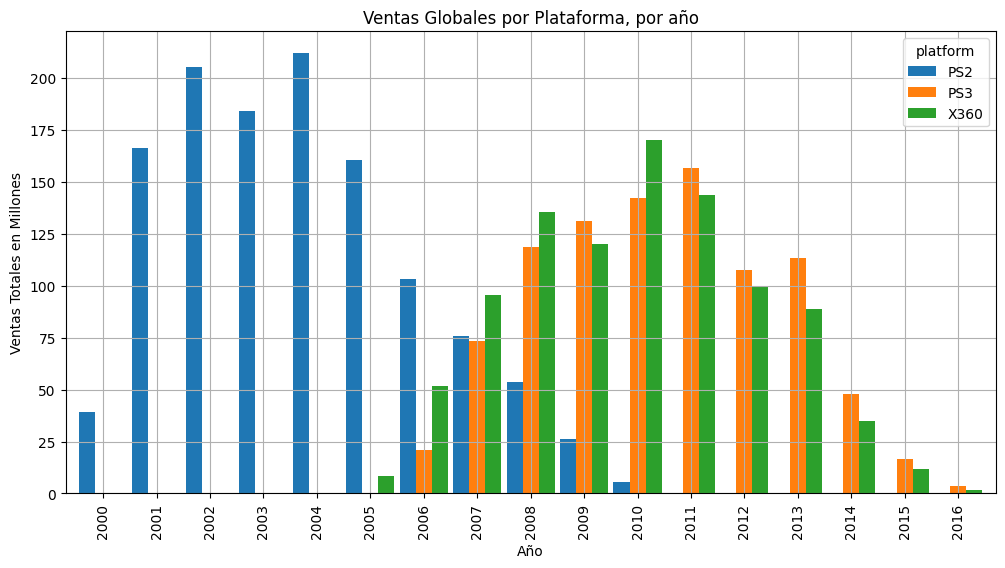

In [22]:
# Plataformas con las mayores ventas totales y distribución basada en los datos de cada año.
top_platforms = sales_per_platform.head(3).index
sales_by_year_platform = df_games[df_games["platform"].isin(top_platforms)].groupby(["year_of_release","platform"])\
    ["global_sales"].sum().reset_index()

# Filtrar por plataforma
pivot_sales_by_year_platform = sales_by_year_platform.pivot(index= 'year_of_release', columns= 'platform', values= 'global_sales')

# Graficar las observaciones
pivot_sales_by_year_platform.plot(
    title='Ventas Globales por Plataforma, por año',
    kind= 'bar',
    grid=True,
    xlabel= 'Año',
    ylabel= 'Ventas Totales en Millones',
    width= 0.9,
    rot= 90,
    figsize= (12,6)
)
plt.show()

### 3.3 Ciclo de Vida de las Plataformas, por Marca

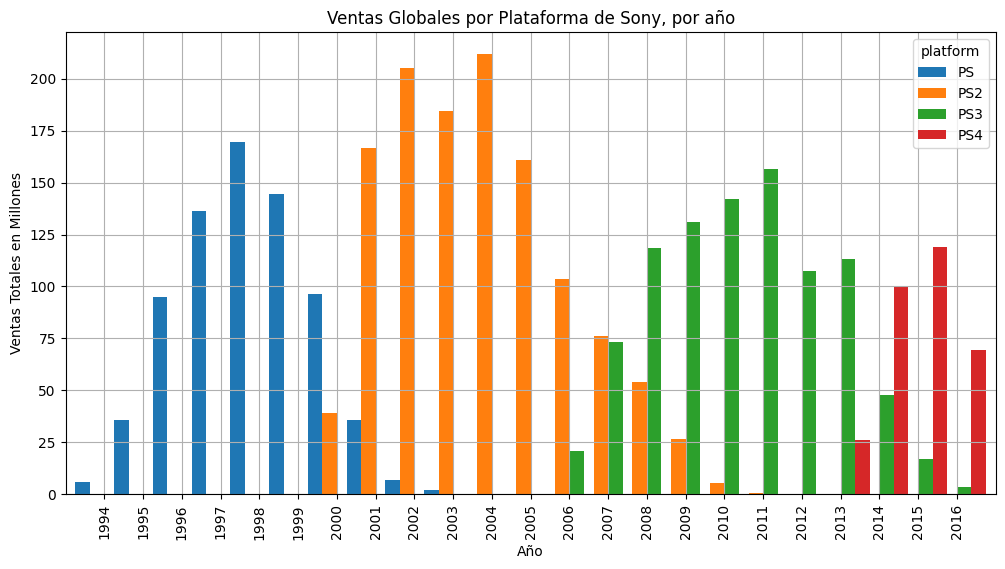

In [23]:
# Plataformas que solían ser populares pero que ahora no tienen ventas
# Grafica para plataformas que solian ser populares pero que ahora no tienen ventas (Sony)
ps_platforms = df_games[df_games["platform"].isin(['PS', 'PS2', 'PS3', 'PS4'])].groupby(["year_of_release","platform"])\
    ["global_sales"].sum().reset_index()

# Filtrar por plataforma
pivot_ps_platforms = ps_platforms.pivot(index= 'year_of_release', columns= 'platform', values= 'global_sales')

# Graficar las observaciones
pivot_ps_platforms.plot(
    title='Ventas Globales por Plataforma de Sony, por año',
    kind= 'bar',
    grid=True,
    xlabel= 'Año',
    ylabel= 'Ventas Totales en Millones',
    width= 1.5,
    rot= 90,
    figsize= (12,6)
)
plt.show()


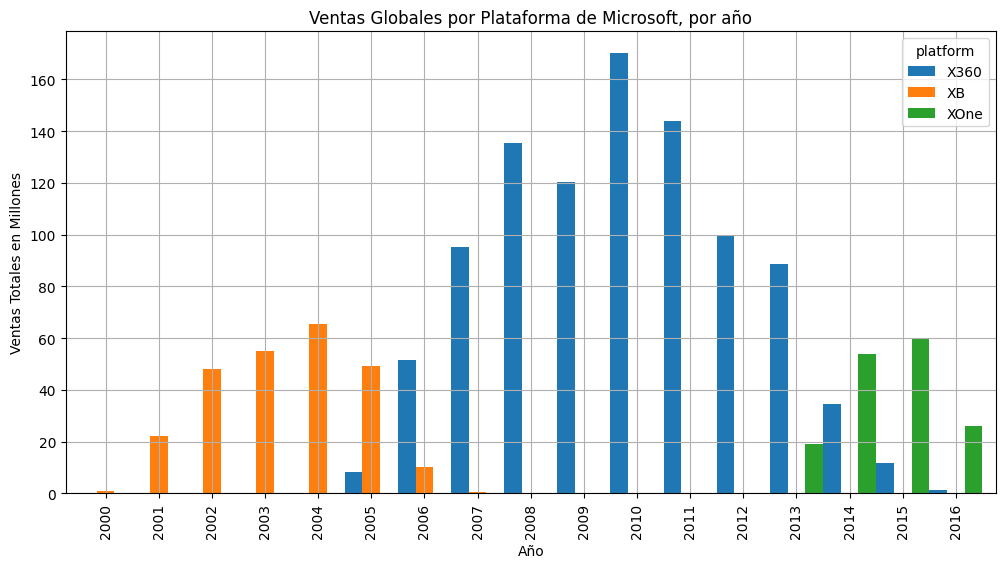

In [24]:
# Grafica para plataformas que solian ser populares pero que ahora no tienen ventas (Microsoft)
x_platforms = df_games[df_games["platform"].isin(['XB', 'XOne', 'X360'])].groupby(["year_of_release","platform"])\
    ["global_sales"].sum().reset_index()

# Filtrar por plataforma
pivot_x_platforms = x_platforms.pivot(index= 'year_of_release', columns= 'platform', values= 'global_sales')

# Graficar las observaciones
pivot_x_platforms.plot(
    title='Ventas Globales por Plataforma de Microsoft, por año',
    kind= 'bar',
    grid=True,
    xlabel= 'Año',
    ylabel= 'Ventas Totales en Millones',
    width= 1,
    rot= 90,
    figsize= (12,6)
)
plt.show()

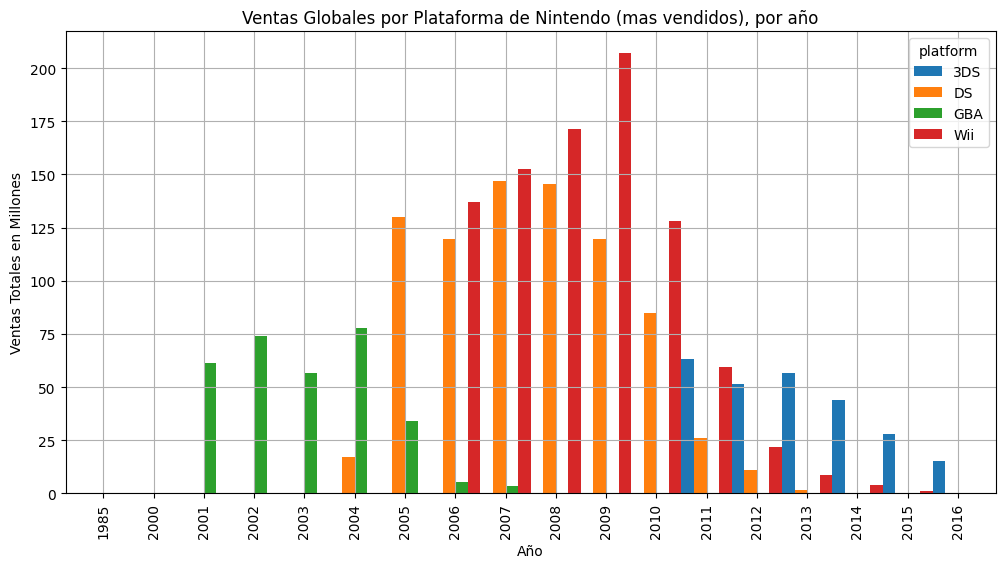

In [25]:
# Grafica para plataformas que solian ser populares pero que ahora no tienen ventas (Nintendo "en Top 10")
nin_platforms = df_games[df_games["platform"].isin(['Wii', 'DS', 'GBA', '3DS'])].groupby(["year_of_release","platform"])\
    ["global_sales"].sum().reset_index()

# Filtrar por plataforma
pivot_nin_platforms = nin_platforms.pivot(index= 'year_of_release', columns= 'platform', values= 'global_sales')

# Graficar las observaciones
pivot_nin_platforms.plot(
    title='Ventas Globales por Plataforma de Nintendo (mas vendidos), por año',
    kind= 'bar',
    grid=True,
    xlabel= 'Año',
    ylabel= 'Ventas Totales en Millones',
    width= 1,
    rot= 90,
    figsize= (12,6)
)
plt.show()

¿Cuánto tardan generalmente las nuevas plataformas en aparecer y las antiguas en desaparecer? <br>
Determina para qué período debes tomar datos. <br>
<br>
En lo general, el ciclo de vida de una consola (plataforma) es de aprox 5 a 7 años, antes de comenzar su declive hastas desaparecer. <br>
Entonces, para un pronostico mas acertado del 2017, tomare como parametro el periodo 2012 - 2016 (donde el punto minimo de cualquier plataforma en el punto mas alto), y captura las tendencias de las consolas.

### 3.4 Filtrado de Datos Relevantes

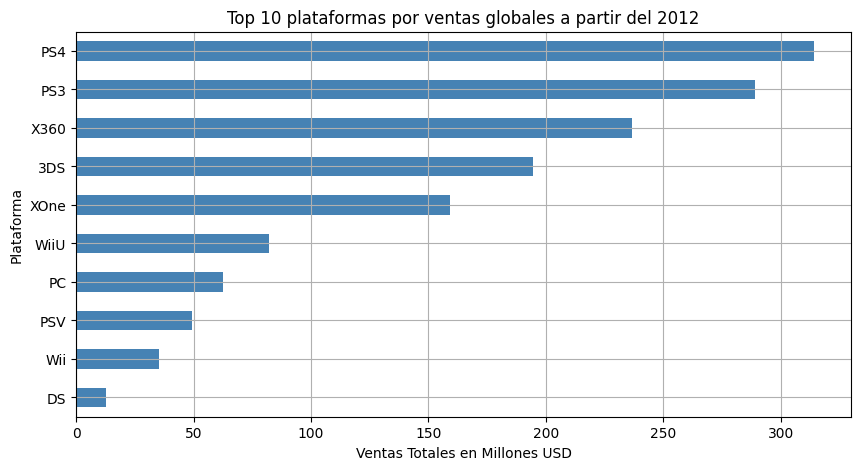

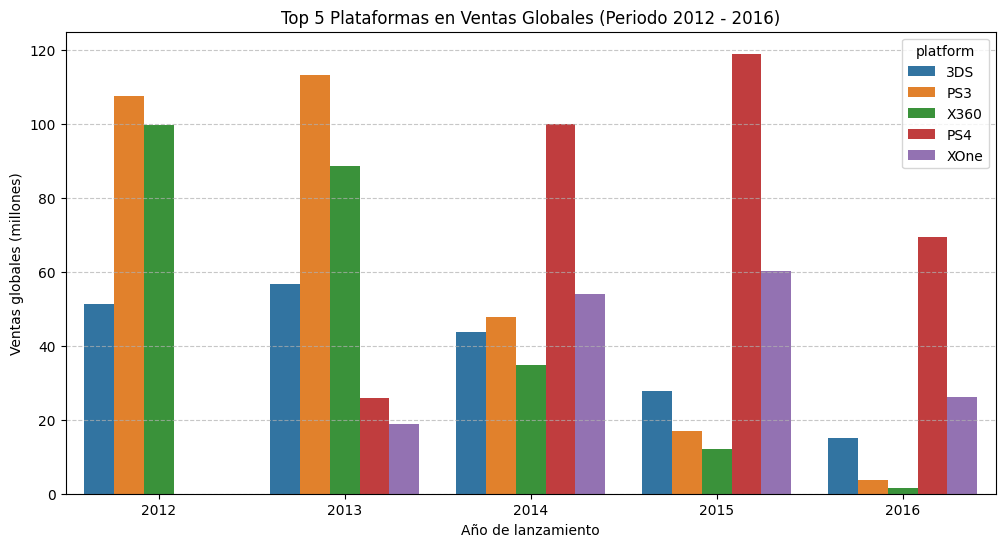

In [26]:
# Datos a partir del 2012
sales_per_platform_5y = df_games[df_games['year_of_release'] >= 2012]
sales_5y = sales_per_platform_5y.groupby(by='platform')['global_sales'].sum()
sales_5y = sales_5y.sort_values(ascending=False)

# Graficar las observaciones
ax_5y = sales_5y.head(10).plot(
    title= 'Top 10 plataformas por ventas globales a partir del 2012',
    kind="barh",
    figsize=(10,5),
    grid=True,
    color= 'steelblue',
    ylim=(15,30),
    xlabel="Plataforma",
    ylabel="Ventas Totales en Millones USD"
)
ax_5y.set_xlabel("Ventas Totales en Millones USD")
ax_5y.invert_yaxis()
plt.show()

# Elegimos las plataformas mas representativas (Top5)
top_platforms = sales_5y.head(5).index.tolist()
sales_by_year_platform = df_games[(df_games['year_of_release'] >= 2012) & (df_games['platform'].isin(top_platforms))
].groupby(['year_of_release', 'platform'])['global_sales'].sum().reset_index()

# Graficar las observaciones
plt.figure(figsize=(12,6))
sns.barplot(data=sales_by_year_platform, x='year_of_release', y='global_sales', hue='platform')
plt.title('Top 5 Plataformas en Ventas Globales (Periodo 2012 - 2016)')
plt.xlabel('Año de lanzamiento')
plt.ylabel('Ventas globales (millones)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


¿Qué plataformas son líderes en ventas? ¿Cuáles crecen y cuáles se reducen? <br>
<br>
Comparando la primera grafica del proyecto (donde se toman todos los datos historicos del dataframe) con esta grafica, donde solo se toman desde el 2012 a 2016, se puede observar lo siguiente: <br>
El top 5 global con datos historicos se encuentran: PS2, X360, PS3, Wii, DS <br>
El top 5 global con datos a partir de 2012 se encuentran: PS4. PS3, X360, 3DS, XOne <br>
Las plataformas lideres en ventas se posicionan Sony (con PS4 y PS3), y Microsoft (X360 y XOne). Respecto a Nintendo, pierde un poco el terreno, logrando mantener en el Top5 solamente 3DS.

### 3.5 Ventas Globales por Juegos

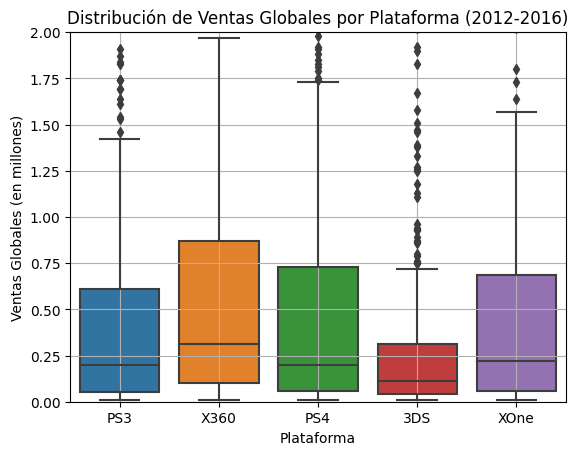

In [27]:
# Diagrama de caja para las ventas globales de todos los juegos, desglosados por plataforma.
df_box = df_games[(df_games['year_of_release'] >= 2012) & (df_games['platform'].isin(top_platforms))]

sns.boxplot(x='platform', y='global_sales', data=df_box)
plt.title('Distribución de Ventas Globales por Plataforma (2012-2016)')
plt.xlabel('Plataforma')
plt.ylabel('Ventas Globales (en millones)')
plt.ylim(0, 2)
plt.grid(True)
plt.show()

¿Son significativas las diferencias en las ventas? <br>
Tomando como referencia este top 5 de plataformas en ventas globales, del periodo 2012 - 2016, tenemos que las medianas de las plataformas (a excepcion de X360) se mantienen en un punto entre 0 - 0.25 (en mill). Esto pudiera traducirse en que, el numero de los grandes exitos no son relativamente altos, predominan las bajas ventas del resto de Videojuegos. Para el caso del X360 existe mayor variabilidad, y es el que muestra mayor numero de exitos (concentrando sus ventas dentro de sus cuartiles).

### 3.6 Correlaciones

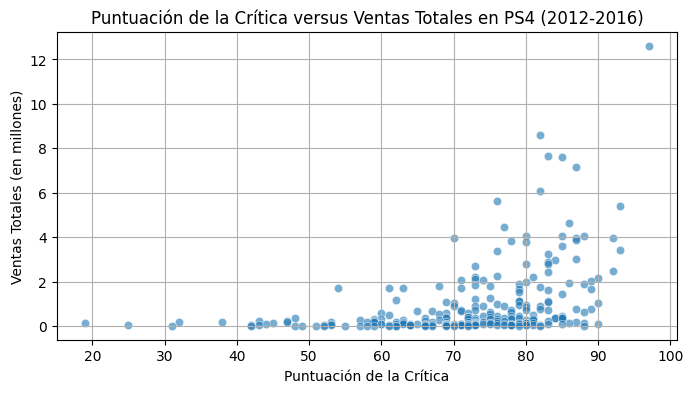

La correlacion entre las reseñas de los criticos y las ventas es: 0.5078289176410228



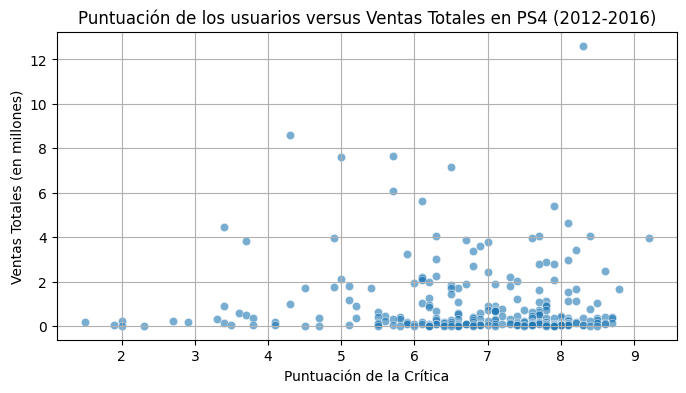

La correlacion entre las reseñas de los usuarios y las ventas es: -0.032430263114838286



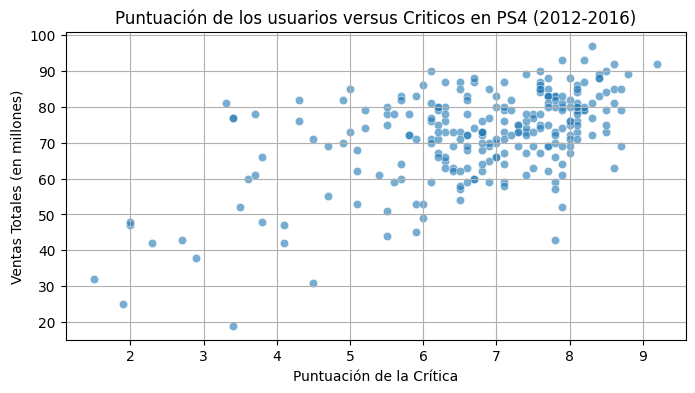

La correlacion entre las reseñas de los usuarios y de los criticos es: 0.43330907203128555


In [28]:
# Reseñas de usuarios y profesionales en ventas de PS4
df_5y = df_games[df_games['year_of_release'] >= 2012].copy()
ps4_data = df_5y[df_5y['platform'] == 'PS4'].dropna(subset=['critic_score', 'user_score'])

# Correlacion
correlation_critic = ps4_data['critic_score'].corr(ps4_data['global_sales'], method= "spearman")
correlation_user = ps4_data['user_score'].corr(ps4_data['global_sales'], method= "spearman")
correlation_critic_user = ps4_data['user_score'].corr(ps4_data['critic_score'], method= "spearman")

# Grafico de Dispersion: critic score vs sales
plt.figure(figsize=(8, 4))
sns.scatterplot(x='critic_score', y='global_sales', data=ps4_data, alpha=0.6)
plt.title('Puntuación de la Crítica versus Ventas Totales en PS4 (2012-2016)')
plt.xlabel('Puntuación de la Crítica')
plt.ylabel('Ventas Totales (en millones)')
plt.grid(True)
plt.show()
print(f'La correlacion entre las reseñas de los criticos y las ventas es: {correlation_critic}')
print()

# Grafico de Dispersion: user score vs sales
plt.figure(figsize=(8, 4))
sns.scatterplot(x='user_score', y='global_sales', data=ps4_data, alpha=0.6)
plt.title('Puntuación de los usuarios versus Ventas Totales en PS4 (2012-2016)')
plt.xlabel('Puntuación de la Crítica')
plt.ylabel('Ventas Totales (en millones)')
plt.grid(True)
plt.show()
print(f'La correlacion entre las reseñas de los usuarios y las ventas es: {correlation_user}')
print()

# Grafico de Dispersion: user score vs critic score
# Comparativa entre las resenas entre los usuarios y los criticos
plt.figure(figsize=(8, 4))
sns.scatterplot(x='user_score', y='critic_score', data=ps4_data, alpha=0.6)
plt.title('Puntuación de los usuarios versus Criticos en PS4 (2012-2016)')
plt.xlabel('Puntuación de la Crítica')
plt.ylabel('Ventas Totales (en millones)')
plt.grid(True)
plt.show()
print(f'La correlacion entre las reseñas de los usuarios y de los criticos es: {correlation_critic_user}')

La puntuacion de la critica tiene una correlacion medianamente positiva. Esto puede traducirse a que, las mejores puntuaciones tienden a asociarse con mejores ventas. <br>
En contraparte, la puntuacion de los usuarios casi no tiene relacion. <br>
Finalmente y como conclusion, se puede tomar como parametro la puntuacion de la critica para predecir un exito comercial en futuros juegos.

### 3.7 Ventas de Juegos por Plataforma

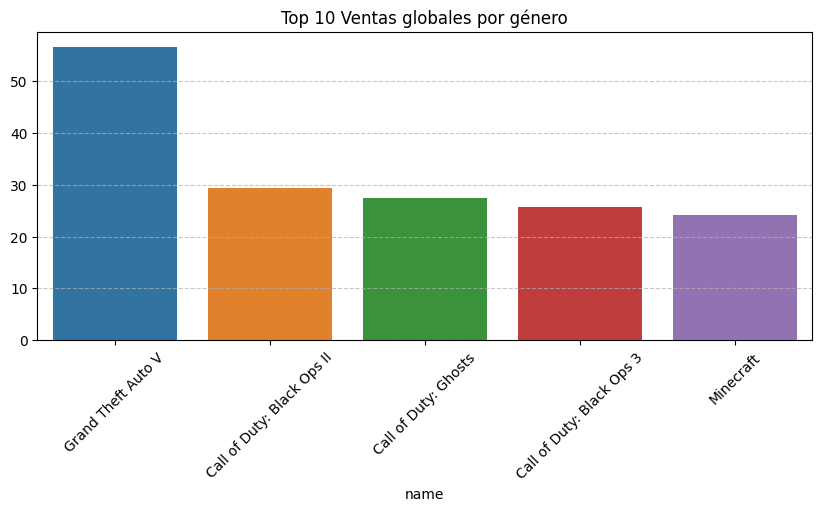

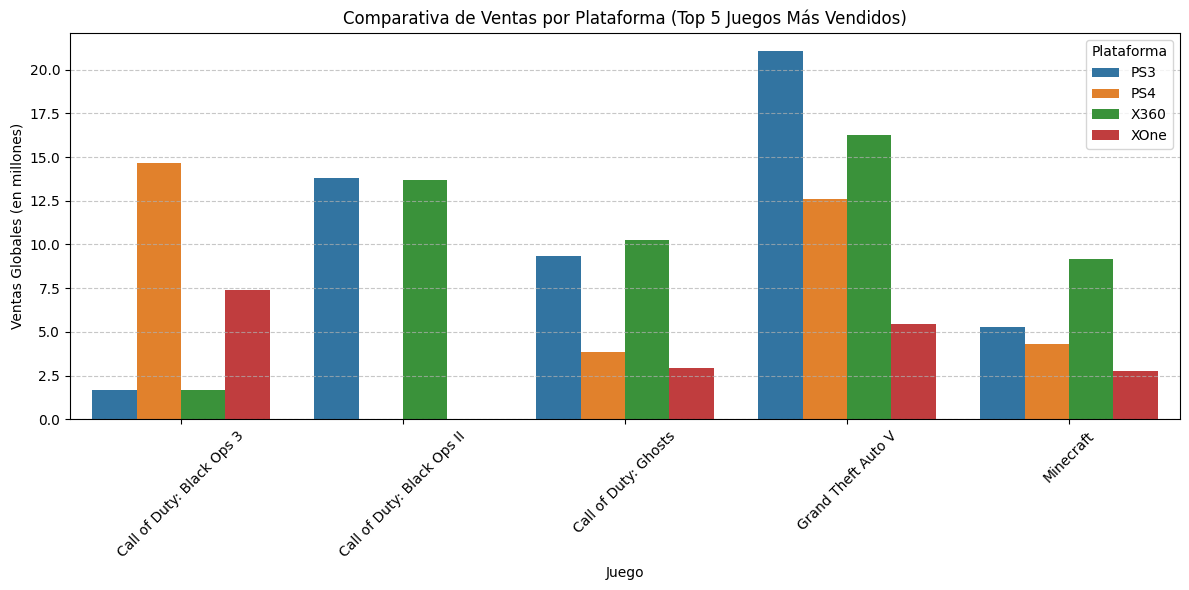

In [29]:
# Teniendo en cuenta tus conclusiones compara las ventas de los mismos juegos en otras plataformas.
# Primero, calculo del top 5 de Juegos vendidos Globales. 
games_platforms = df_5y.groupby('name')['global_sales'].sum().sort_values(ascending=False).head(5)

# Graficar los resultados
plt.figure(figsize=(10,4))
sns.barplot(x=games_platforms.index, y=games_platforms.values)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.title('Top 10 Ventas globales por género')
plt.show()

# Top 5 de Plataformas respecto a ventas globales
top5_list = games_platforms.index.tolist()
platforms_to_compare = ['PS3', 'X360', 'PS4', '3DS', 'XOne']

# Filtro de Datos
df_top5_platforms = df_5y[(df_5y['name'].isin(top5_list)) & (df_5y['platform'].isin(platforms_to_compare))]
sales_comparison = (df_top5_platforms.groupby(['name', 'platform'])['global_sales'].sum().reset_index())

# Graficar la comparativa juegos por plataforma.
plt.figure(figsize=(12,6))
sns.barplot(data=sales_comparison, x='name', y='global_sales', hue='platform')
plt.title('Comparativa de Ventas por Plataforma (Top 5 Juegos Más Vendidos)')
plt.xlabel('Juego')
plt.ylabel('Ventas Globales (en millones)')
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Plataforma')
plt.tight_layout()
plt.show()

### 3.8 Ventas Globales por Genero

Action          1031
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64


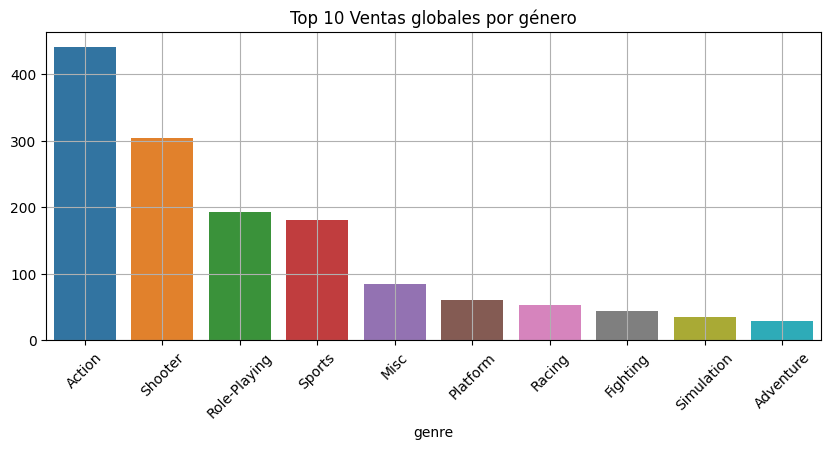

In [30]:
# Distribucion de juegos por Genero
genre_sales = df_5y.groupby('genre')['global_sales'].sum().sort_values(ascending=False).head(10)
genre_counts = df_5y['genre'].value_counts()
print(genre_counts)

# Graficar la distribucion
plt.figure(figsize=(10,4))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Top 10 Ventas globales por género')
plt.show()

Los generos mas rentables (top 3), son los generos de "Action", "Shooter" y "Role-Playing". Esta informacion resulta ser crucial para el departamento, ya que, con la informacion de los criticos, podria tomarse como parametro para la proyeccion del 2017

# 4. Crear Perfil de Usuario por Región

### 4.1 Plataformas por Region

platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: na_sales, dtype: float64


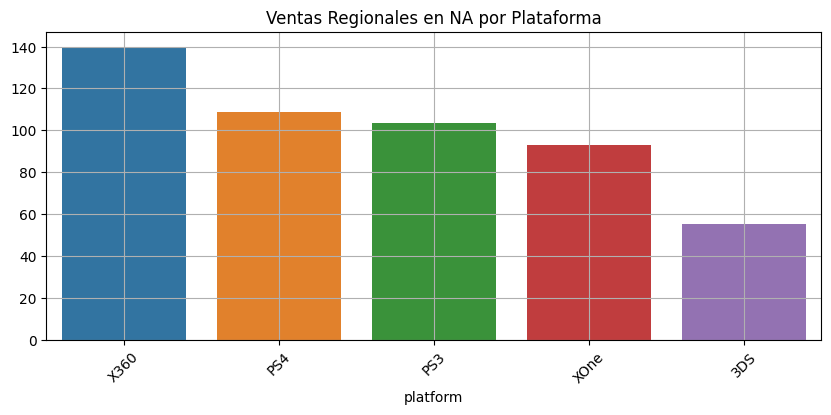

platform
PS4     141.09
PS3     106.85
X360     74.52
XOne     51.59
3DS      42.64
Name: eu_sales, dtype: float64


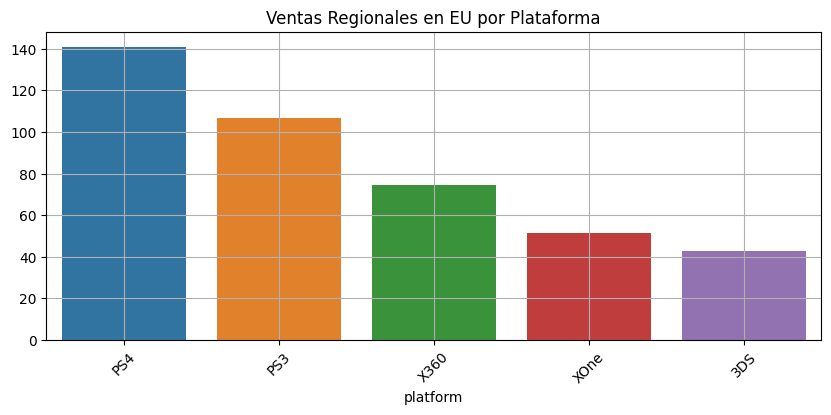

platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: jp_sales, dtype: float64


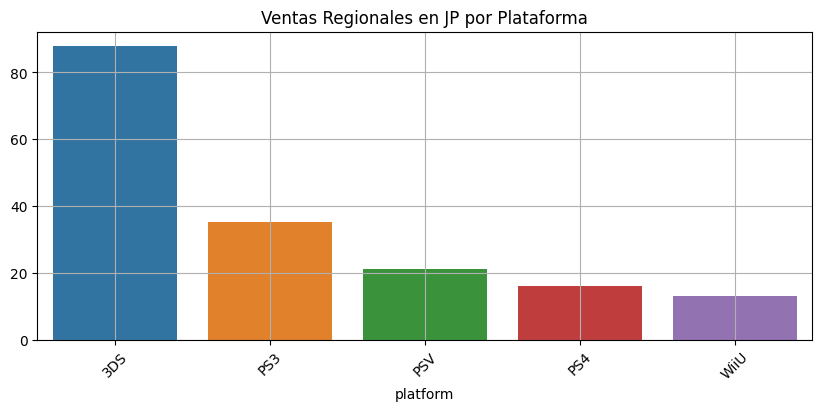

In [31]:
# Las cinco plataformas principales por region
na_platforms = df_5y.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_platforms = df_5y.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_platforms = df_5y.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Graficar NA
print(na_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=na_platforms.index, y=na_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en NA por Plataforma')
plt.show()

# Graficar EU
print(eu_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_platforms.index, y=eu_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en EU por Plataforma')
plt.show()

# Graficar JP
print(jp_platforms)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_platforms.index, y=jp_platforms.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en JP por Plataforma')
plt.show()

# Describe las variaciones en sus cuotas de mercado de una región a otra.
# Acorde a lo visto, del 

Conclusiones de las plataformas <br>
Tanto en EU como en NA, tenemos una similitud respecto a las preferencias en plataformas de Sony y Microsoft. <br>
En NA, el preferido es el X360, seguido de 2 de las plataformas de Sony. En EU, el favorito es PS4, seguido del PS3 y seguido de Microsoft. <br>
El nicho en las ventas en JP es marcada la diferencia hacia el Nintendo DS, seguido de plataformas de Sony. No aparecen en el Top5 alguna plataforma de Microsoft.

### 4.2 Generos por Region

genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: na_sales, dtype: float64


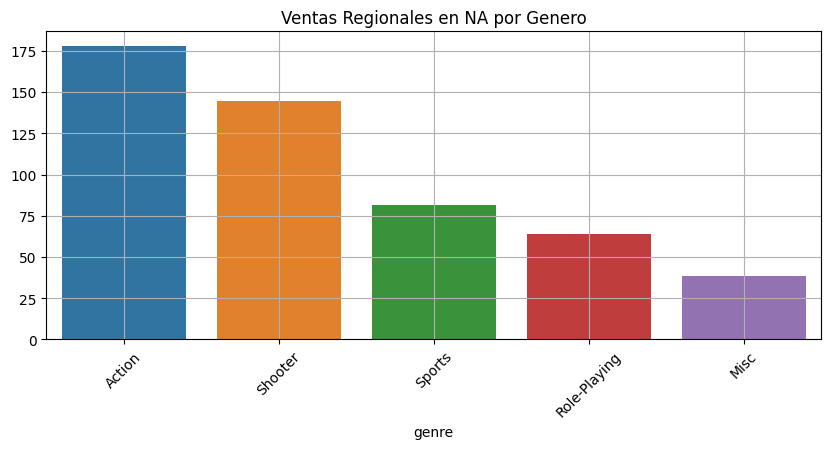

genre
Action          159.34
Shooter         113.47
Sports           69.08
Role-Playing     48.53
Racing           27.29
Name: eu_sales, dtype: float64


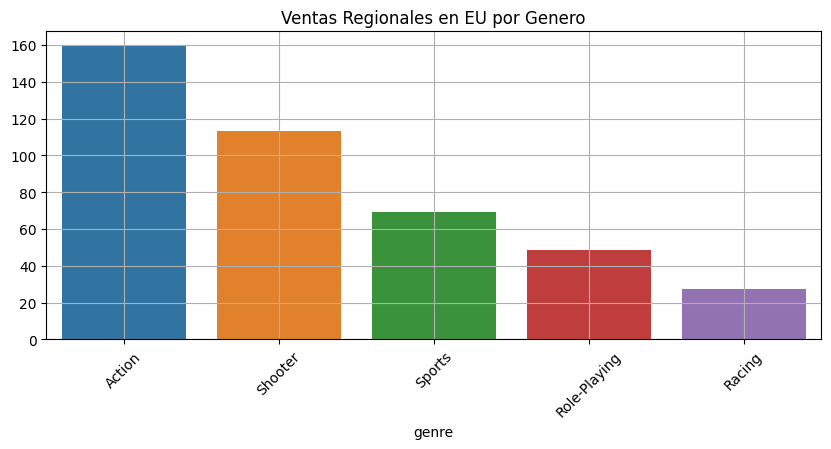

genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: jp_sales, dtype: float64


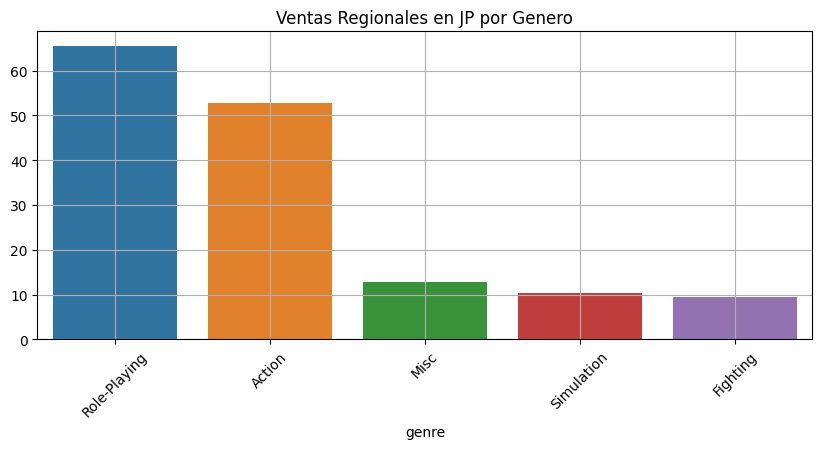

In [32]:
# Top 5 géneros principales por Region
na_genres = df_5y.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_genres = df_5y.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_genres = df_5y.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Graficar NA
print(na_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=na_genres.index, y=na_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en NA por Genero')
plt.show()

# Graficar EU
print(eu_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_genres.index, y=eu_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en EU por Genero')
plt.show()

# Graficar JP
print(jp_genres)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_genres.index, y=jp_genres.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en JP por Genero')
plt.show()

Conclusiones <br>
Para el caso de NA y EU, tienen bastantes similitudes en cuanto a preferencias de Juegos, siendo similares en el top 4: "Action", "Shooter", "Sports" y "Role-Playing". <br>
En el caso de JP, los generos Favoritos cambian significativamente, teniendo como favorito a "Role-Playing", "Action" y "Misc". <br>
Esto parece interesante, ya que no parecen tener similitudes tanto las regiones de EU y NA, como en JP. 

### 4.3 Relacion Clasificaciones ESRB con Ventas Regionales 

rating
M       231.57
E       114.37
E10+     75.70
T        66.02
Name: na_sales, dtype: float64


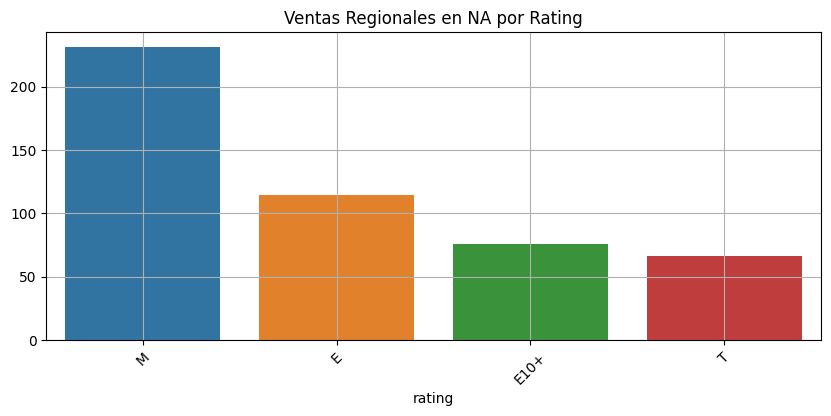

rating
M       193.96
E       113.02
E10+     55.37
T        52.96
Name: eu_sales, dtype: float64


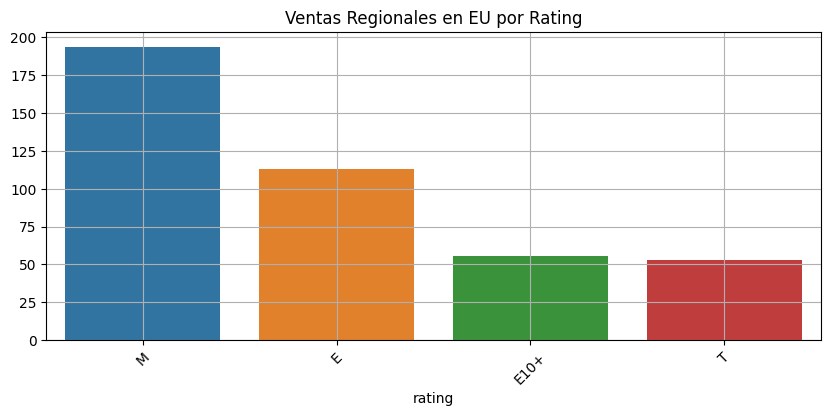

rating
E       28.33
T       26.02
M       21.20
E10+     8.19
Name: jp_sales, dtype: float64


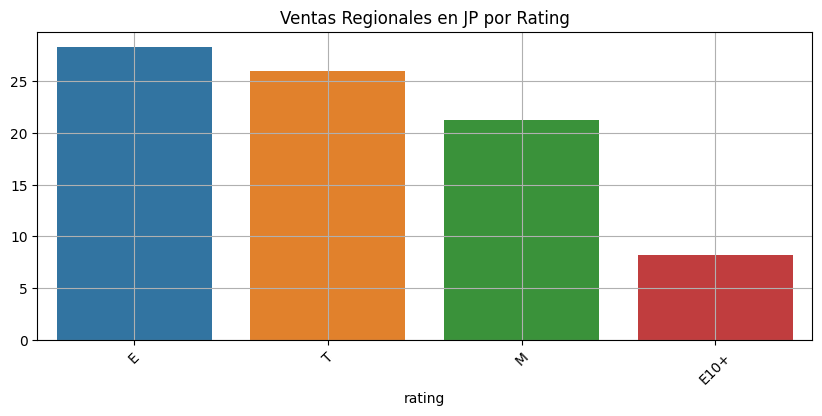

In [33]:
# Clasificaciones de ESRB afectan a las ventas en regiones individuales.
# Top 5 géneros principales por Region
na_rating = df_5y.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_rating = df_5y.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_rating = df_5y.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head(5)

# Graficar NA
print(na_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=na_rating.index, y=na_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en NA por Rating')
plt.show()

# Graficar EU
print(eu_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=eu_rating.index, y=eu_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en EU por Rating')
plt.show()

# Graficar JP
print(jp_rating)
plt.figure(figsize=(10,4))
sns.barplot(x=jp_rating.index, y=jp_rating.values)
plt.grid(True)
plt.xticks(rotation=45)
plt.title('Ventas Regionales en JP por Rating')
plt.show()

La conclusion del Rating vs Ventas por region es, que definitivamente JP se muestra como un nicho unico, diferenciandose de EU y NA (estos mostrandose muy similares) <br>
Respecto a EU y NA, el rating favorito es "M", y para el caso de JP es "E".

# 5. Probar Hipótesis

Hipotesis 1:<br>
- H0: No existe diferencia entre las calificaciones promedio de los usuarios para las plataformas Xbox One y PC.<br>
    media_user_score("XOne") = media_user_score("PC") <br>
- H1: Existe diferencia entre las calificaciones promedio de los usuarios para las plataformas Xbox One y PC.<br>
    media_user_score("XOne") ≠ media_user_score("PC") 

Hipotesis 2: <br>
- H0: No existe diferencia entre las calificaciones promedio de los usuarios para los géneros de Acción y Deportes.<br>
    media_user_score("action") = media_user_score("sports") <br>
- H1: Existe diferencia entre las calificaciones promedio de los usuarios para los géneros de Acción y Deportes.<br>
    media_user_score("action") ≠ media_user_score("sports")

In [34]:
# Nivel de Significancia
alpha = 0.05

### 5.1 Hipotesis tomando datos historicos

nivel de significancia: 0.05

Valor para la prueba de Levene es:  0.27955
No se rechaza la hipotesis nula, dado que las varianzas no son Distintas

El resultado estadistico es: -4.3828953
El p_value es:  0.0000130
Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios por plataforma no son iguales



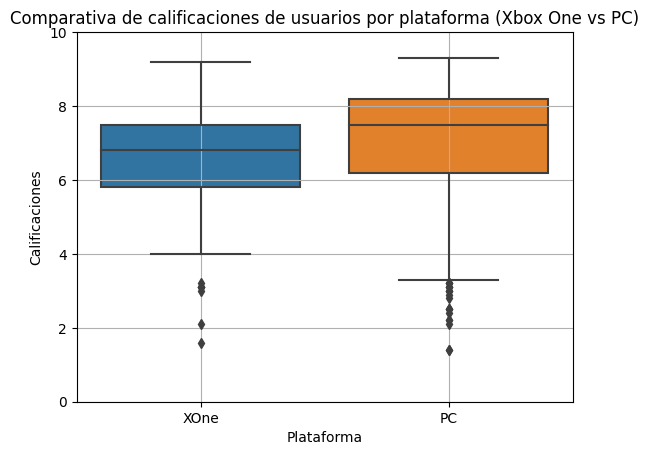

In [35]:
# Hipotesis 1:

# Filtrado de Datos (XOne vs PC)
xone_score = df_games[(df_games['platform'] == 'XOne') & (df_games['user_score'].notna())]['user_score']
pc_score = df_games[(df_games['platform'] == 'PC') & (df_games['user_score'].notna())]['user_score']
# print('N XOne:', xone_score.shape[0], 'N PC:', pc_score.shape[0])
print(f'nivel de significancia: {alpha}')
print()

# Agrupacion de datos en nuevas columnas
xone_df = pd.DataFrame({'platform': ['XOne'] * len(xone_score), 'user_score': xone_score.values})
pc_df = pd.DataFrame({'platform': ['PC'] * len(pc_score), 'user_score': pc_score.values})
concat_xone_pc = pd.concat([xone_df, pc_df], ignore_index=True)

# Resolucion de Hipotesis
# Evaluacion de varianzas (XOne vs PC) mediante prueba de Levene
statistics, p_value = stats.levene(xone_score, pc_score)
print(f'Valor para la prueba de Levene es: {p_value: .5f}')
if (p_value < alpha):
    print("Se rechaza la hipotesis nula, dado que las varianzas son Distintas")
else:
    print("No se rechaza la hipotesis nula, dado que las varianzas no son Distintas")
print()

# Para este caso, mediante la evaluacion de varianzas (prueba de Levene), se demostro que las varianzas no son distintas.
# Entonces, se utilizara para demostrar las hipotesis, la prueba t de 2 colas
t_stat, p_value = stats.ttest_ind(xone_score, pc_score, equal_var=True)
print(f'El resultado estadistico es: {t_stat: .7f}')
print(f'El p_value es: {p_value: .7f}')

if p_value < alpha:
    print("Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios por plataforma no son iguales")
else:
    print("No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios por plataforma son iguales")
print()

# Diagrama de caja para mostrar las comparaciones.
sns.boxplot(x= 'platform', y= 'user_score', data=concat_xone_pc)
plt.title("Comparativa de calificaciones de usuarios por plataforma (Xbox One vs PC)")
plt.xlabel('Plataforma')
plt.ylabel('Calificaciones')
plt.ylim(0,10)
plt.grid(True)
plt.show()

nivel de significancia: 0.05

Valor para la prueba de Levene es:  0.00009
Se rechaza la hipotesis nula, dado que las varianzas son Distintas

El resultado estadistico es:  1.7661671
El p_value es:  0.0775167
No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios son iguales



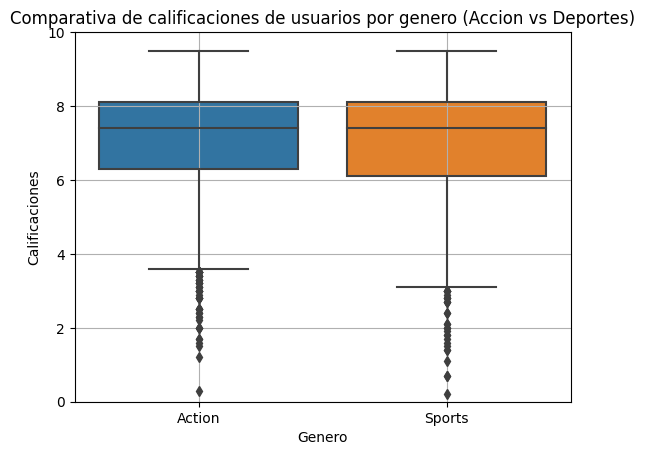

In [36]:
# Hipotesis 2: 

# Filtrado de Datos (Action vs Sports)
action_score = df_games[(df_games['genre'] == 'Action') & (df_games['user_score'].notna())]['user_score']
sports_score = df_games[(df_games['genre'] == 'Sports') & (df_games['user_score'].notna())]['user_score']
# print('N Action:', action_score.shape[0], 'N Sports:', sports_score.shape[0])
print(f'nivel de significancia: {alpha}')
print()

# Agrupacion de datos en nuevas columnas
action_df = pd.DataFrame({'genre': ['Action'] * len(action_score), 'user_score': action_score.values})
sports_df = pd.DataFrame({'genre': ['Sports'] * len(sports_score), 'user_score': sports_score.values})
concat_action_sports = pd.concat([action_df, sports_df], ignore_index=True)

# Resolucion de Hipotesis
# Evaluacion de varianzas (action vs sports) mediante prueba de Levene
statistics, p_value = stats.levene(action_score, sports_score)
print(f'Valor para la prueba de Levene es: {p_value: .5f}')
if (p_value < alpha):
    print("Se rechaza la hipotesis nula, dado que las varianzas son Distintas")
else:
    print("No se rechaza la hipotesis nula, dado que las varianzas no son Distintas")
print()

# Para este caso, mediante la evaluacion de varianzas (prueba de Levene), se demostro que las varianzas son distintas.
t_stat, p_value = stats.ttest_ind(action_score, sports_score, equal_var=False)
print(f'El resultado estadistico es: {t_stat: .7f}')
print(f'El p_value es: {p_value: .7f}')

if p_value < alpha:
    print("Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios no son iguales")
else:
    print("No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios son iguales")
print()

# Diagrama de caja para mostrar las comparaciones.
sns.boxplot(x= 'genre', y= 'user_score', data=concat_action_sports)
plt.title("Comparativa de calificaciones de usuarios por genero (Accion vs Deportes)")
plt.xlabel('Genero')
plt.ylabel('Calificaciones')
plt.ylim(0,10)
plt.grid(True)
plt.show()

### 5.2 Hipotesis tomando datos del ciclo de vida de las plataformas (5y)

nivel de significancia: 0.05

Valor para la prueba de Levene es:  0.01251
Se rechaza la hipotesis nula, dado que las varianzas son Distintas

El resultado estadistico es:  0.5998586
El p_value es:  0.5489538
No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios por plataforma son iguales



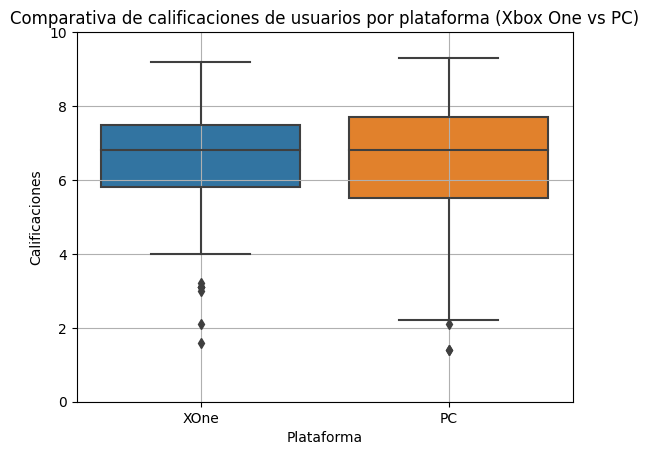

In [37]:
# Hipotesis 1:

# Filtrado de Datos (XOne vs PC)
xone_score_5y = df_5y[(df_5y['platform'] == 'XOne') & (df_5y['user_score'].notna())]['user_score']
pc_score_5y = df_5y[(df_5y['platform'] == 'PC') & (df_5y['user_score'].notna())]['user_score']
# print('N XOne:', xone_score.shape[0], 'N PC:', pc_score.shape[0])
print(f'nivel de significancia: {alpha}')
print()

# Agrupacion de datos en nuevas columnas
xone_df_5y = pd.DataFrame({'platform': ['XOne'] * len(xone_score_5y), 'user_score': xone_score_5y.values})
pc_df_5y = pd.DataFrame({'platform': ['PC'] * len(pc_score_5y), 'user_score': pc_score_5y.values})
concat_xone_pc_5y = pd.concat([xone_df_5y, pc_df_5y], ignore_index=True)

# Resolucion de Hipotesis
# Evaluacion de varianzas (XOne vs PC) mediante prueba de Levene
statistics, p_value = stats.levene(xone_score_5y, pc_score_5y)
print(f'Valor para la prueba de Levene es: {p_value: .5f}')
if (p_value < alpha):
    print("Se rechaza la hipotesis nula, dado que las varianzas son Distintas")
else:
    print("No se rechaza la hipotesis nula, dado que las varianzas no son Distintas")
print()

# Para este caso, mediante la evaluacion de varianzas (prueba de Levene), se demostro que las varianzas son distintas.
t_stat, p_value = stats.ttest_ind(xone_score_5y, pc_score_5y, equal_var=False)
print(f'El resultado estadistico es: {t_stat: .7f}')
print(f'El p_value es: {p_value: .7f}')

if p_value < alpha:
    print("Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios por plataforma no son iguales")
else:
    print("No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios por plataforma son iguales")
print()

# Diagrama de caja para mostrar las comparaciones.
sns.boxplot(x= 'platform', y= 'user_score', data=concat_xone_pc_5y)
plt.title("Comparativa de calificaciones de usuarios por plataforma (Xbox One vs PC)")
plt.xlabel('Plataforma')
plt.ylabel('Calificaciones')
plt.ylim(0,10)
plt.grid(True)
plt.show()

nivel de significancia: 0.05

Valor para la prueba de Levene es: 1.045718795108326e-05
Se rechaza la hipotesis nula, dado que las varianzas son Distintas

El resultado estadistico es: 9.863487132322389
El p_value es: 5.989458066467418e-20
Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios no son iguales



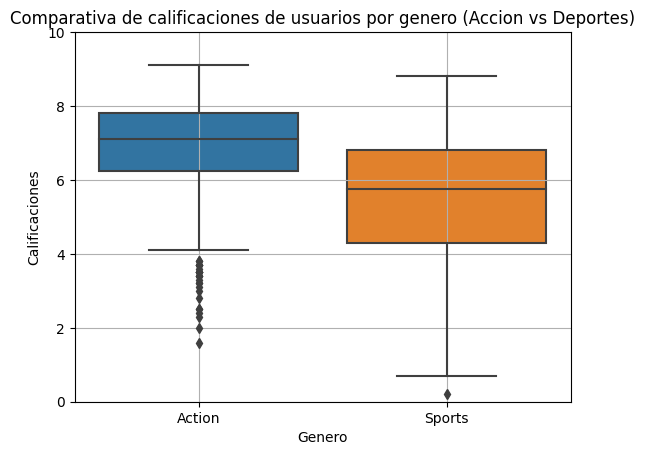

In [38]:
# Hipotesis 2: 

# Filtrado de Datos (Action vs Sports)
action_score_5y = df_5y[(df_5y['genre'] == 'Action') & (df_5y['user_score'].notna())]['user_score']
sports_score_5y = df_5y[(df_5y['genre'] == 'Sports') & (df_5y['user_score'].notna())]['user_score']
# print('N Action:', action_score.shape[0], 'N Sports:', sports_score.shape[0])
print(f'nivel de significancia: {alpha}')
print()

# Agrupacion de datos en nuevas columnas
action_df_5y = pd.DataFrame({'genre': ['Action'] * len(action_score_5y), 'user_score': action_score_5y.values})
sports_df_5y = pd.DataFrame({'genre': ['Sports'] * len(sports_score_5y), 'user_score': sports_score_5y.values})
concat_action_sports_5y = pd.concat([action_df_5y, sports_df_5y], ignore_index=True)

# Resolucion de Hipotesis
# Evaluacion de varianzas (action vs sports) mediante prueba de Levene
statistics, p_value = stats.levene(action_score_5y, sports_score_5y)
print(f'Valor para la prueba de Levene es: {p_value}')
if (p_value < alpha):
    print("Se rechaza la hipotesis nula, dado que las varianzas son Distintas")
else:
    print("No se rechaza la hipotesis nula, dado que las varianzas no son Distintas")
print()

# Para este caso, mediante la evaluacion de varianzas (prueba de Levene), se demostro que las varianzas son distintas.
t_stat, p_value = stats.ttest_ind(action_score_5y, sports_score_5y, equal_var=False)
print(f'El resultado estadistico es: {t_stat}')
print(f'El p_value es: {p_value}')

if p_value < alpha:
    print("Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios no son iguales")
else:
    print("No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios son iguales")
print()

# Diagrama de caja para mostrar las comparaciones.
sns.boxplot(x= 'genre', y= 'user_score', data=concat_action_sports_5y)
plt.title("Comparativa de calificaciones de usuarios por genero (Accion vs Deportes)")
plt.xlabel('Genero')
plt.ylabel('Calificaciones')
plt.ylim(0,10)
plt.grid(True)
plt.show()

Cómo formulaste las hipótesis nula y alternativa <br>
Dado que, para comprobar o rechazar las 2 hipotesis planteadas, primero se necesito determinar si las varianzas de las 2 muestras eran iguales o diferentes (tanto para la hipotesis de las calificaciones promedio entre plataformas, como para la hipotesis de las calificaciones promedio de los generos). <br>
<br>
En mi caso particular, realice 2 veces ambas hipotesis (una con los datos totales "historico" del dataframe, y otra solo con los datos del periodo 2012 - 2016), arrojando datos muy interesantes:<br>
Para el caso de los datos historicos, se demostro que las varianzas de ambos muestreos "XOne" y "PC" eran similares, por lo que procedi a utilizar la prueba Tstudent tradicional. Al final, Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios por plataforma no son iguales <br>
Para esa misma hipotesis con datos del periodo 2012 - 2016, se demostro que las varianzas de ambos muestreos "XOne" y "PC" eran distintos, aqui se utilizo la prueba T de Welch. Al final, No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios por plataforma son iguales <br>
<br>
Para el caso de los datos historicos, se demostro que las varianzas de ambos muestreos "Action" y "Sports" eran distintas, por lo que procedi a utilizar la prueba T de Welch. Al final, No podemos rechazar la hipotesis nula, dado que hay suficiente evidencia que compruebe, que las calificaciones promedio de los usuarios son iguales <br>
Para esa misma hipotesis con datos del periodo 2012 - 2016, se demostro que las varianzas de ambos muestreos "XOne" y "PC" eran distintos, aqui se utilizo la prueba T de Welch. Al final, Se rechaza la hipotesis nula, dado que las calificaciones promedio de los usuarios no son iguales <br>

# 6. Conclusión

Este análisis se realizó con el objetivo de identificar patrones de éxito en los videojuegos para la tienda online Ice, utilizando datos históricos hasta diciembre de 2016 para planificar la campaña publicitaria de 2017. <br>
La primera etapa crucial fue la preparación de los datos, que incluyó el manejo de una cantidad significativa de valores ausentes, especialmente en critic_score y user_score, y la conversión de tipos de datos, como la estandarización de "tbd" a NaN en las puntuaciones de usuario.
Finalmente, selecciono los puntos clave del proyecto a considerar <br>
- Período Relevante Identificado: El análisis del ciclo de vida de las consolas muestra que su vida comercial activa es de 5 a 7 años. Por lo tanto, para predecir 2017, se utilizaron datos del período 2012-2016, descartando datos históricos obsoletos.
- Plataformas con Potencial: En 2016, las plataformas de la generación anterior (PS3, X360) estaban en claro declive. Las plataformas con mayor potencial de ventas y crecimiento para 2017 eran PS4 y XOne. <br>
<br>
Factores Clave de Ventas (Global): <br>
<br>
- Las puntuaciones de la crítica (critic_score) tienen una correlación positiva moderada (aprox. 0.51) con las ventas globales. Son un indicador fiable para predecir el éxito.
- Las puntuaciones de los usuarios (user_score) no mostraron una correlación significativa (aprox. -0.03).
- Géneros Más Rentables: A nivel global, los géneros más exitosos y que generan más ingresos en el período relevante fueron Action (Acción), Shooter (Disparos) y Role-Playing (Juegos de Rol). <br>
<br>
Perfil de Mercado (NA y EU): <br>
<br>
- Norteamérica y Europa son mercados muy similares.
- Plataformas preferidas: PS4 y XOne (Sony y Microsoft).
- Géneros preferidos: Action y Shooter.
- Rating preferido: "M" (Mature - Adulto).<br>
<br>
Perfil de Mercado (JP): <br>
<br>
- El mercado japonés es completamente diferente y requiere una estrategia separada.
- Plataformas preferidas: 3DS y PSV (dominio de las portátiles de Nintendo y Sony).
- Géneros preferidos: Role-Playing.
- Rating preferido: "E" (Everyone - Para todos).<br>
<br>
Resultados de Hipótesis (Período 2012-2016): <br>
<br>
- Se aceptó la hipótesis nula para plataformas: Las calificaciones promedio de usuarios entre XOne y PC no son significativamente diferentes (P-value > 0.05).
- Se rechazó la hipótesis nula para géneros: Las calificaciones promedio de usuarios entre Acción y Deportes sí son significativamente diferentes (P-value < 0.05). <br>
<br>
Recomendación Estratégica para 2017: <br>
<br>
- Para NA/EU: Invertir en publicidad para juegos de "Acción" y "Shooter" con altas calificaciones de la crítica en las consolas PS4 y XOne.
- Para JP: Enfocar la publicidad en juegos de "Role-Playing" para la plataforma 3DS.